## Coarse-graining approach for barotropic vorticity budget analysis

The notebook is for analyzing coarse-grained vorticity budget terms. The terms are coarse-grained using fixed kernel width (set in km). The coarse-graining is performed for different kernel sizes. Vorticity balances are analysed as a function of length-scale in different ocean basins.

The barotrpic vorticity budget is

\begin{equation}
   \beta \, V = \frac{J(p_b,H)}{\rho_o}
 + \frac{\nabla \wedge\tau_s}{\rho_o} - \frac{\nabla \wedge\tau_b}{\rho_o} 
+\nabla \wedge \mathcal{A}
+\nabla \wedge\mathcal{B} -f \, \frac{Q_m}{\rho_o} + f \, \partial_t\eta - \nabla \wedge \mathcal{U}_t.
\end{equation}

We coase-grain each of the vorticity budget term to obtain corase-grained fileds, $F_\ell({\bf{x}})$, by convoluting with a normalising top-hat filter kernel, $G_\ell$, 

\begin{equation}
    F_\ell({\bf{x}}) = G_\ell * F({\bf{x}})
\end{equation}

To analyse the relative magnitudes of vorticity terms as a function of length-scale, we compute the domain-mean of absolute values of vorticity terms at different length scale in different regions of interest. We further normalise these domain values to examine relative importance of different terms,

\begin{equation}
   \{|F_\ell|\} = \frac{\sum_i w_i |F_\ell({\bf{x}_i})|}{\sum_i w_i},
\end{equation}
\begin{equation}
   \{|F_\ell|\} \textit{(normalized)}= \frac{\{|F_\ell|\}_j}{\sum_j \{|F_\ell|\}_j},
\end{equation}

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import regionmask
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', aspect_rt = 1.0):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    #cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    #cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    #ax.coastlines()
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(-80,81,20))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(aspect_rt)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    #ax.add_feature(cfeature.LAND, facecolor='grey')
    #ax.add_feature(cfeature.COASTLINE)
    
    _ = plt.title(title, fontsize=14)
    return p

In [3]:
def plot_globe(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
               lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', grid_label = None):
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap,
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.8)
    cb.ax.tick_params(labelsize=12)
    
    #ax.coastlines()
    
    #ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')

    if(grid_label != None):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylocator = mticker.FixedLocator(np.arange(-60,81,30))
        gl.xlocator = mticker.FixedLocator(np.arange(-180,180,60))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.add_feature(cfeature.LAND, facecolor='grey')
    #ax.add_feature(cfeature.COASTLINE)
    
    _ = plt.title(title, fontsize=14)
    return fig

In [4]:
# Read coarse-grained data

ppdir = "../../Data/Coarse_grain/Vorticity_Budget/"

ds_km = []

for i in range(100, 2050, 100):
    #print('km scale = ', i)
    ds = xr.open_dataset(ppdir + "km_filter/filter_" + str(i) + "km.nc")
    ds_km.append(ds)
    
ds_km = xr.concat(ds_km, dim='filter_scale')
ds_km = ds_km.isel(time=0, depth=0).compute()


In [5]:
print(ds_km)

<xarray.Dataset>
Dimensions:     (latitude: 720, longitude: 1440, filter_scale: 20)
Coordinates:
    time        float64 0.0
    depth       float64 0.0
  * latitude    (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude   (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: filter_scale
Data variables:
    cell_areas  (filter_scale, latitude, longitude) float64 1.686e+06 ... 1.6...
    beta_V      (filter_scale, latitude, longitude) float64 0.0 ... 2.455e-12
    BPT         (filter_scale, latitude, longitude) float64 4.136e-25 ... 4.0...
    Curl_Adv    (filter_scale, latitude, longitude) float64 0.0 ... -8.942e-13
    Curl_taus   (filter_scale, latitude, longitude) float64 0.0 0.0 ... 3.93e-12
    Curl_taub   (filter_scale, latitude, longitude) float64 6.462e-27 ... -5....
    Curl_diff   (filter_scale, latitude, longitude) float64 0.0 ... -9.211e-13
    Mass_flux   (filter_scale, latitude, longitude) float64 0.0 ... 1

### Regional masking

To examine the balances in individual ocean basins, we use xmip python library. We would like to mainly in six basins - Northern and Southern Atlantic Oceans, Northern and  Southern Pacific Oceans, Indian Ocean, and Southern Ocean (see the plot below). In addition, we would examine the overall balance for the global ocean.

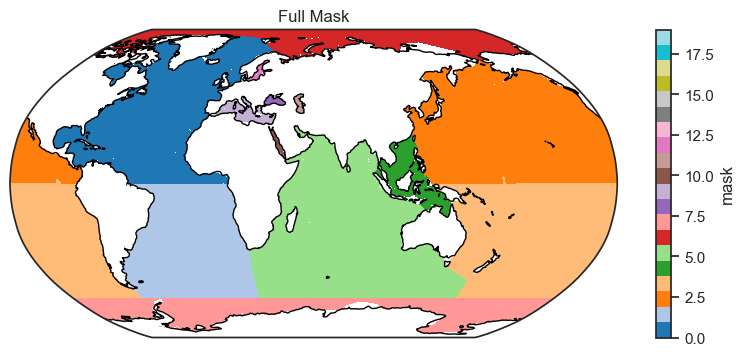

In [6]:
# load ocean basin data

basins = regionmask.defined_regions.natural_earth.ocean_basins_50

mask = merged_mask(basins, ds_km, lon_name="longitude", lat_name="latitude")

kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), infer_intervals=False)

fig, ax = plt.subplots(ncols=1, figsize=[10,4], subplot_kw={'projection':ccrs.Robinson(60)})

mask.plot(cmap='tab20', vmin=0, vmax=19, **kwargs)
ax.set_title(f"Full Mask")
ax.coastlines()

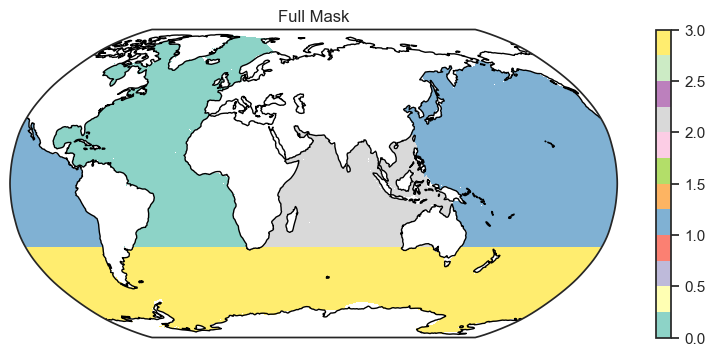

In [7]:
# Create combined mask for Atlantic, Pacific, Indian and Southern Ocean (30S - )

mask1 = mask.copy()

mask1 = mask1.where((mask1 <= -1) & (mask1 >= 20.))

mask1 = xr.where((mask==0) | (mask==1), 0., mask1) # Atlantic

mask1 = xr.where((mask==2) | (mask==3), 1., mask1) # Pacific

mask1 = xr.where((mask==4) | (mask==5), 2., mask1) # Indian

mask1 = xr.where((mask.latitude < -33.) & (mask >= -1) & (mask <= 20.), 3., mask1) # Southern Ocean

# In xr.where(condition, a, b), replace data with a where conditions are satisfied. Otherwise, replace data with b.
# On the other hand, mask.where(condition, b) replaces data with b where conditions are not satisfied satisfied and 
# keeps the original data in mask where conditions are satisfied.

kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), infer_intervals=False)

fig, ax = plt.subplots(ncols=1, figsize=[10,4], subplot_kw={'projection':ccrs.Robinson(60)})

mask1.plot(cmap='Set3', **kwargs)
ax.set_title(f"Full Mask")
ax.coastlines()

In [8]:
# Actual model grid masking
# Mask from region_mask may not agree with actual in model output
# so we read the model native grid for proper masking

ds_mask = xr.open_dataset("../../Data/OM4p25_JRA55_Vorticity_Budget_Regrid_LatLon.nc")
ds_mask = ds_mask.drop(['x', 'y', 'lat', 'lon'])

mask_model = xr.where(np.isnan(ds_mask['BPT']) == False, 1., np.nan)

mask_model = mask_model.rename({'y':'latitude', 'x':'longitude'})
mask_model = mask_model.assign_coords({'latitude': ds_km['latitude'], 'longitude': ds_km['longitude']})

mask_model = xr.where((ds_km['latitude'] > -80.), mask_model, np.nan)

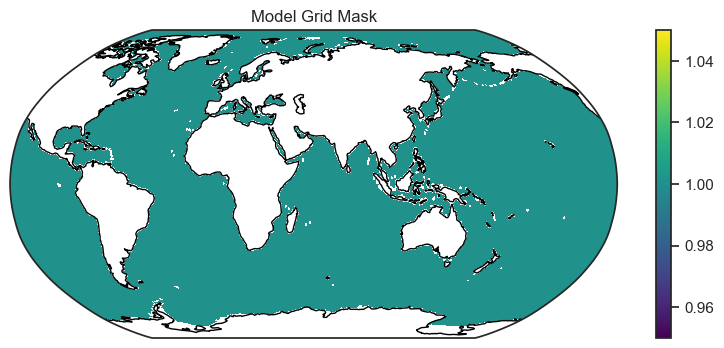

In [9]:
kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), infer_intervals=False)
fig, ax = plt.subplots(ncols=1, figsize=[10,4], subplot_kw={'projection':ccrs.Robinson(60)})

mask_model.plot( **kwargs)
ax.set_title(f"Model Grid Mask")
ax.coastlines()

### Plot all terms in vorticity budget 

It is to set the need for coarse-graining as the spatial structure is quite complicated and it is very diffcult to determine the dominant balance terms


1. Plot global map of vorticity budget terms to emphasise the complicated spatial variability in magnitudes and signs of vorticity budget terms.
2. Plot regional and global vorticity balances as a function of coarse-graining filter width.

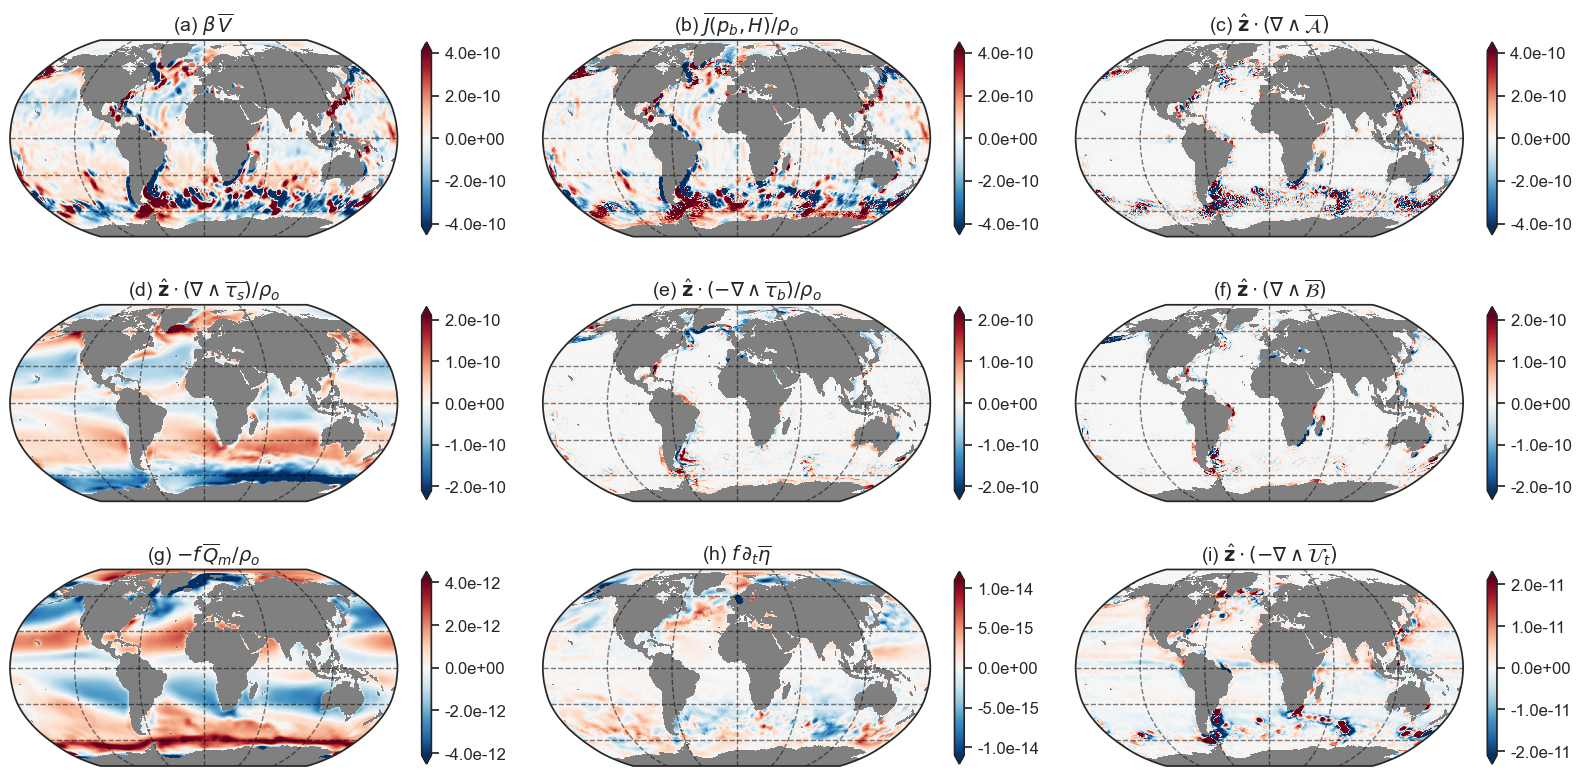

In [10]:
#Macros: {
#      bm: ["\\boldsymbol{#1}",1]
#    }


fldlist = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus','Curl_taub','Curl_diff', 'Mass_flux', 'eta_dt', 'Curl_dudt']

max_r = [4.1e-10, 4.1e-10, 4.1e-10, 2.1e-10, 2.1e-10, 2.1e-10, 4.1e-12, 1.1e-14, 2.1e-11]

labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', 
          r'$\hat{\mathbf{z}} \cdot (\nabla \wedge \overline{\mathcal{A}})$',
          r'$\hat{\mathbf{z}} \cdot (\nabla \wedge\overline{{\tau_s}})/\rho_o$', 
          r'$\hat{\mathbf{z}} \cdot (-\nabla \wedge\overline{{\tau_b}})/\rho_o$',
          r'$\hat{\mathbf{z}} \cdot (\nabla \wedge \overline{\mathcal{B}})$', 
          r'$-f \, \overline{Q}_m/{\rho_o}$', r'$f \, \partial_t\overline{\eta}$',
         r'$\hat{\mathbf{z}} \cdot (-\nabla \wedge \overline{\mathcal{U}_t})$']

ds = ds_km.where(mask_model > 0.)

grid1 = plt.GridSpec(3, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[20,10])

i = 0

for var in fldlist:
    
    ax = fig.add_subplot(grid1[int(i / 3), int(i % 3)], projection=ccrs.Robinson(), facecolor='grey')
    
    tmp = ds[var].isel(filter_scale = 4)
    _ = plot_globe(ax, tmp, vmin=-max_r[i], vmax=max_r[i], vstep=2.e-3*max_r[i], lon='longitude', 
                   lat='latitude', cmap='RdBu_r', title='(' + chr(97+i)+ ') ' + labels[i])
    
    i = i + 1 
    
fig.savefig('../../Plots/JAMES_Revision/Budget_Terms.jpg',dpi=300,bbox_inches='tight');
#fig.savefig('../../Plots/JAMES_Revision/Budget_Terms.png',dpi=300,bbox_inches='tight');

## North Atlantic Region

We start with analyis in the North Atlantic Ocean (30-70 N), which has been considered in previous studies, e.g. Corre et al. (2020) and Yeager (2015). This is to ensure that results from coars-graining approach are consistent with previous works looking at vorticity budgets.

In [11]:
# Example for North Atlantic (30-70 N, Corre et al., 2020)

fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']
area = ds_km['cell_areas'].sel(latitude = slice(30., 70.), 
                               longitude = slice(-80., 0.)).isel(filter_scale=0).where(mask1 == 0.)
    
ds = ds_km.sel(latitude = slice(30., 70.), longitude = slice(-80., 0.)).where(mask1 == 0.) 
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

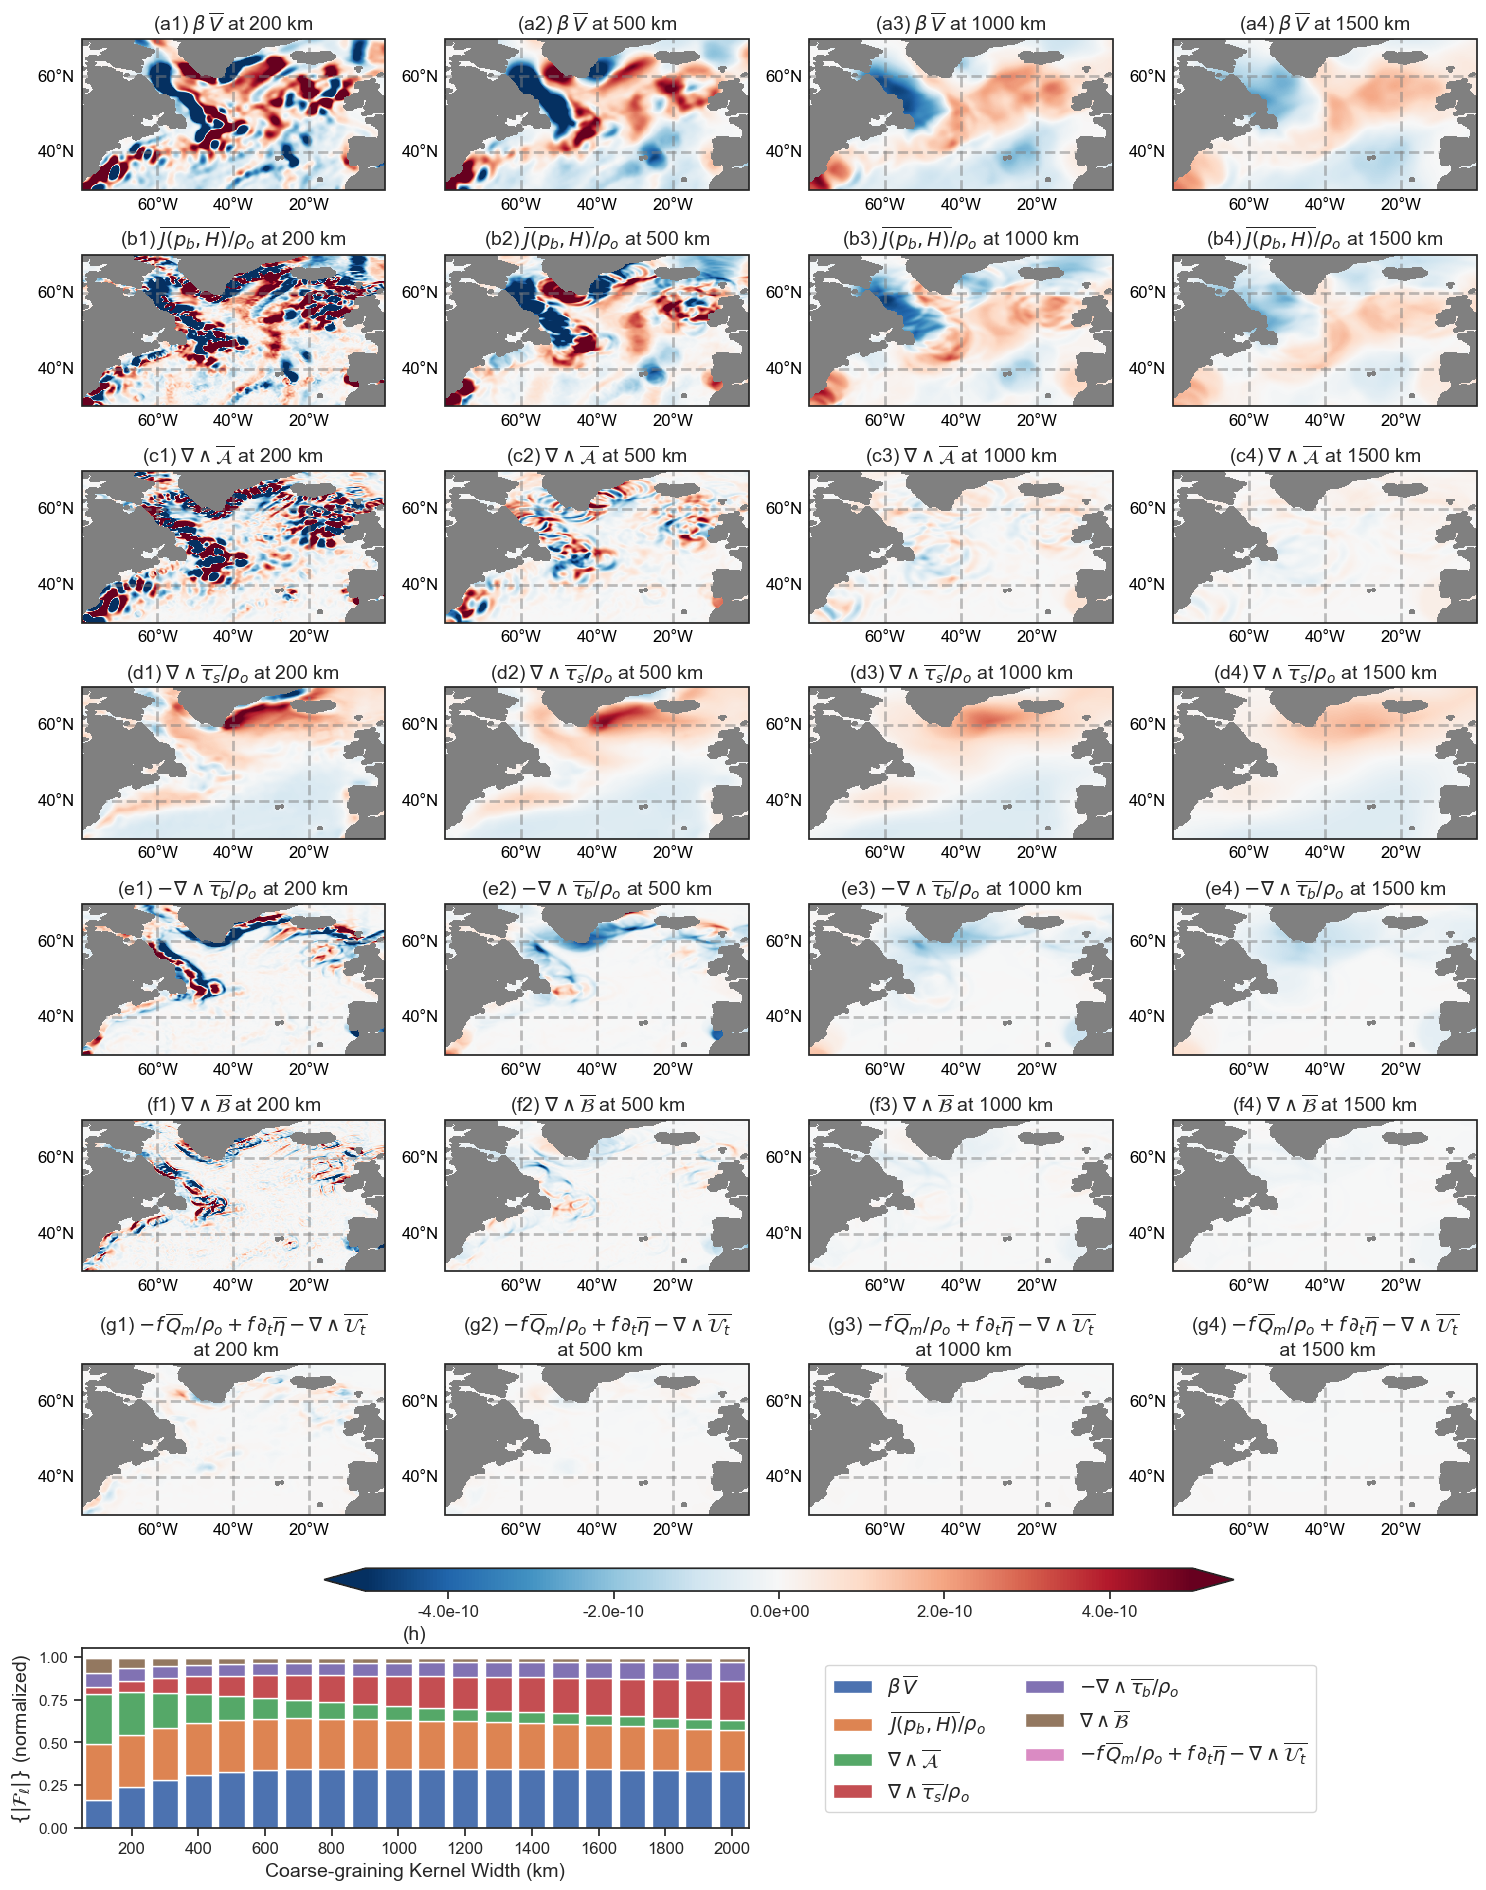

In [12]:
# Plot all terms for filtered in km

ds = (ds_km.sel(longitude=slice(-90., 0.), latitude = slice(10, 70))).where(mask_model ==1.)

lat_lon_ext = [-80., 0., 30., 70.]
max_r = 0.5e-9

grid1 = plt.GridSpec(8, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,22])

ind = [1, 4, 9, 14] # 2, 5, 10 and 15 deg
j = 0

ax1 = [] 

for i in ind:
    
    ax = fig.add_subplot(grid1[0, j],projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['beta_V'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(97)+str(j+1) + ') ' + r'$\beta \, \overline{V}$ at ' + str((i+1)*100)+' km')
    if(j==0):
        plt.ylabel(r'$\beta \times V$', fontsize=14)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[1, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['BPT'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(98)+str(j+1) + ') ' + r'$\overline{J(p_b, H)}/\rho_o$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[2, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_Adv'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(99)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{A}}$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[3, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taus'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(100)+str(j+1) + ') ' + r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[4, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taub'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(101)+str(j+1) + ') '  + r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[5, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_diff'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(102)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{B}}$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[6, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, (ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt']).isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(103)+str(j+1) + ') ' + #'Remaining terms at '
                 r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$' + '\n at '
                 + str((i+1)*100)+' km')

    bbox=plt.gca().get_position()
    offset=.005
    plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
    
    ax1.append(ax)
    
    j = j + 1
    
# $-f \times Q_m / \rho_o + f \partial_t\eta - \nabla \wedge \mathcal{U}_t$
#cb = fig.colorbar(p, ax=ax1, extend='both', orientation="horizontal", shrink=0.3)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(-2.8, -0.5, 3., 3.),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, format='%.1e', extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

# plot rlative magnitudes of domain-mean absolute values
var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Rest']
labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
          r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$', r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$',
          r'$\nabla \wedge \overline{\mathcal{B}}$',
         r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$']

width = 0.8 
d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[7, 0:2])

bbox=plt.gca().get_position()
offset=.02
plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
ax.set_xlim([0.5, 20.5])

bot = 0.  
pos = - 0.0
width = 0.8

norm_fac = d['beta_V'] + d['BPT'] + d['Curl_Adv'] + d['Curl_taus'] + d['Curl_taub'] + d['Curl_diff'] + d['Rest']


for var in var_name:
    
    tmp = d[var] / norm_fac
        
    plt.bar(scale + pos, tmp, width, bottom=bot)
        
    pos = pos + 0.*width
        
    bot = bot + tmp

ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14)   
ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$ (normalized)', fontsize=14)
ax.set_title("(h)", fontsize=14)
plt.xticks(np.arange(2,21,2), np.arange(200, 2100, 200), fontsize=12);

ax.legend(labels, loc='center left', ncol=2,  bbox_to_anchor=(1.1, 0.5), fontsize=14)

#fig.savefig('../../Plots/JAMES_Revision/North_Atlantic_Budget.png',dpi=300,bbox_inches='tight');
fig.savefig('../../Plots/JAMES_Revision/North_Atlantic_Budget.jpg',dpi=300,bbox_inches='tight');

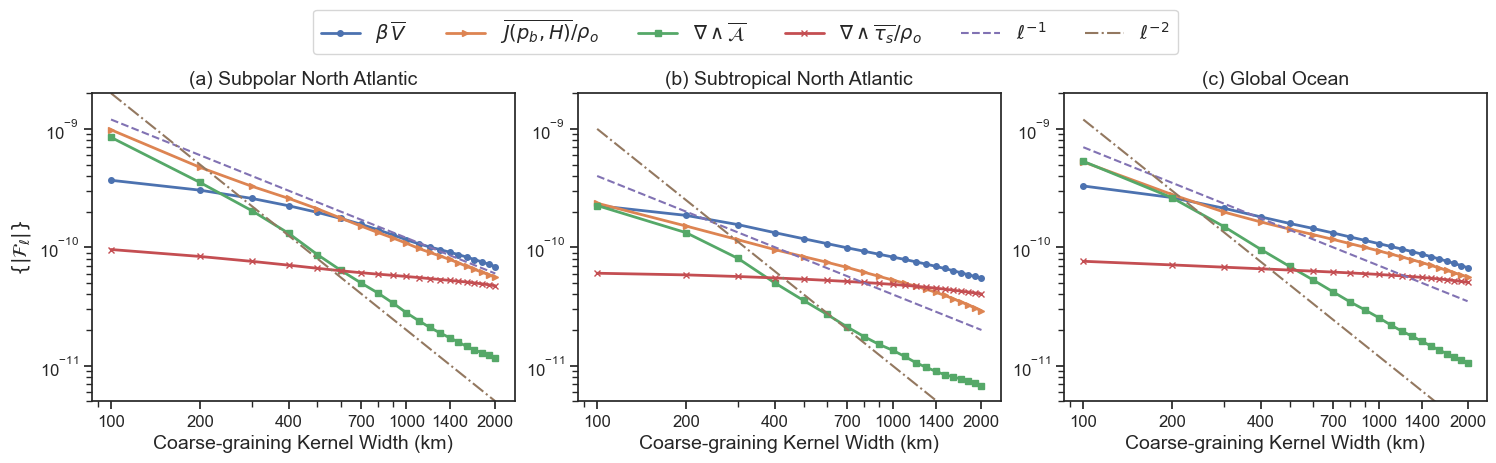

In [32]:
# scaling laws for vorticity budget terms
# use two regions (subpolar North Atlantic and subtropical North Atlantic)


grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.15)
fig = plt.figure(figsize=[18,4])


fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']

var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus'] #, 'Curl_taub', 'Curl_diff', 'Rest']
labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
          r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$']

# Subpolar region (80W-0, 40N-70N)
area = ds_km['cell_areas'].sel(latitude = slice(45., 70.), 
                               longitude = slice(-80., 0.)).isel(filter_scale=0).where(mask1 == 0.)
    
ds = ds_km.sel(latitude = slice(45., 70.), longitude = slice(-80., 0.)).where(mask1 == 0.) 
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[0, 0])
i=0
marke = ['o', '>', 's', 'x']
for var in var_name:
    plt.loglog(scale, d[var], ls ='-', lw=2, marker= marke[i], ms=4, label=labels[i])
    i=i+1

ax.loglog(scale, 1.2e-9/scale, '--', label=r'$\ell^{-1}$')
ax.loglog(scale, 2e-9/scale**2, '-.', label=r'$\ell^{-2}$')
ax.legend(loc='center left', ncol=6,  bbox_to_anchor=(0.5, 1.2), fontsize=14)
#ax.grid('on', ls='--')
tick_Labels = [r'100', r'2$^{\circ}$', r'4$^{\circ}$', r'6$^{\circ}$', r'8$^{\circ}$', r'10$^{\circ}$',
               r'14$^{\circ}$', r'20$^{\circ}$']
plt.xticks([1,2,4,7,10,14,20], [100,200,400,700,1000,1400,2000], fontsize=12);
plt.yticks(fontsize=12)
ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14);  
ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$', fontsize=14);
ax.set_title(r'(a) Subpolar North Atlantic', fontsize=14)
ax.set_ylim([0.5e-11, 2.e-9])


# Subtropical region (80W-0, 10N-40N)
area = ds_km['cell_areas'].sel(latitude = slice(20., 45.), 
                               longitude = slice(-80., 0.)).isel(filter_scale=0).where(mask1 == 0.)
    
ds = ds_km.sel(latitude = slice(20., 45.), longitude = slice(-80., 0.)).where(mask1 == 0.) 
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[0, 1])
i=0
marke = ['o', '>', 's', 'x']
for var in var_name:
    plt.loglog(scale, d[var], ls ='-', lw=2, marker= marke[i], ms=4, label=labels[i])
    i=i+1

ax.loglog(scale, 0.4e-9/scale, '--', label=r'$\ell^{-1}$')
ax.loglog(scale, 1e-9/scale**2, '-.', label=r'$\ell^{-2}$')
#ax.legend(loc='center left',  bbox_to_anchor=(1., 0.5), fontsize=14)
#ax.grid('on', ls='--')
tick_Labels = [r'100', r'2$^{\circ}$', r'4$^{\circ}$', r'6$^{\circ}$', r'8$^{\circ}$', r'10$^{\circ}$',
               r'14$^{\circ}$', r'20$^{\circ}$']
plt.xticks([1,2,4,7,10,14,20], [100,200,400,700,1000,1400,2000], fontsize=12);
plt.yticks(fontsize=12)
ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14);  
#ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$', fontsize=14);
ax.set_title(r'(b) Subtropical North Atlantic', fontsize=14)
ax.set_ylim([0.5e-11, 2.0e-9])

# # Global region (80W-0, 10N-40N)
area = ds_km['cell_areas'].isel(filter_scale=0).where((mask_model > 0.) & (np.abs(ds_km['latitude']) > 20.))
    
ds = ds_km #.where((mask_model > 0.) & (ds_km['latitude'] > 20.) & (ds_km['latitude'] < -20.))
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[0, 2])
i=0
marke = ['o', '>', 's', 'x']
for var in var_name:
    plt.loglog(scale, d[var], ls ='-', lw=2, marker= marke[i], ms=4, label=labels[i])
    i=i+1

ax.loglog(scale, 0.7e-9/scale, '--', label=r'$\ell^{-1}$')
ax.loglog(scale, 1.2e-9/scale**2, '-.', label=r'$\ell^{-2}$')
#ax.legend(loc='center left',  bbox_to_anchor=(1., 0.5), fontsize=14)
#ax.grid('on', ls='--')
#tick_Labels = [r'100', r'2$^{\circ}$', r'4$^{\circ}$', r'6$^{\circ}$', r'8$^{\circ}$', r'10$^{\circ}$',
#               r'14$^{\circ}$', r'20$^{\circ}$']
plt.xticks([1,2,4,7,10,14,20], [100,200,400,700,1000,1400,2000], fontsize=12);
plt.yticks(fontsize=12)
ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14);  
#ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$', fontsize=14);
ax.set_title(r'(c) Global Ocean', fontsize=14)
ax.set_ylim([0.5e-11, 2.0e-9])

fig.savefig('../../Plots/JAMES_Revision/BPT_NL_Scaling.pdf',dpi=300,bbox_inches='tight');

## Weddell Gyre Region

$85S - 40S$ and $70W - 0$

In [13]:
fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']
area = ds_km['cell_areas'].sel(latitude = slice(-85., -40.), longitude = slice(-70., 0.)).isel(filter_scale=0).where(mask1 == 3.)
    
ds = ds_km.sel(latitude = slice(-85., -40.), longitude = slice(-70., 0.)).where(mask1 == 3.)
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

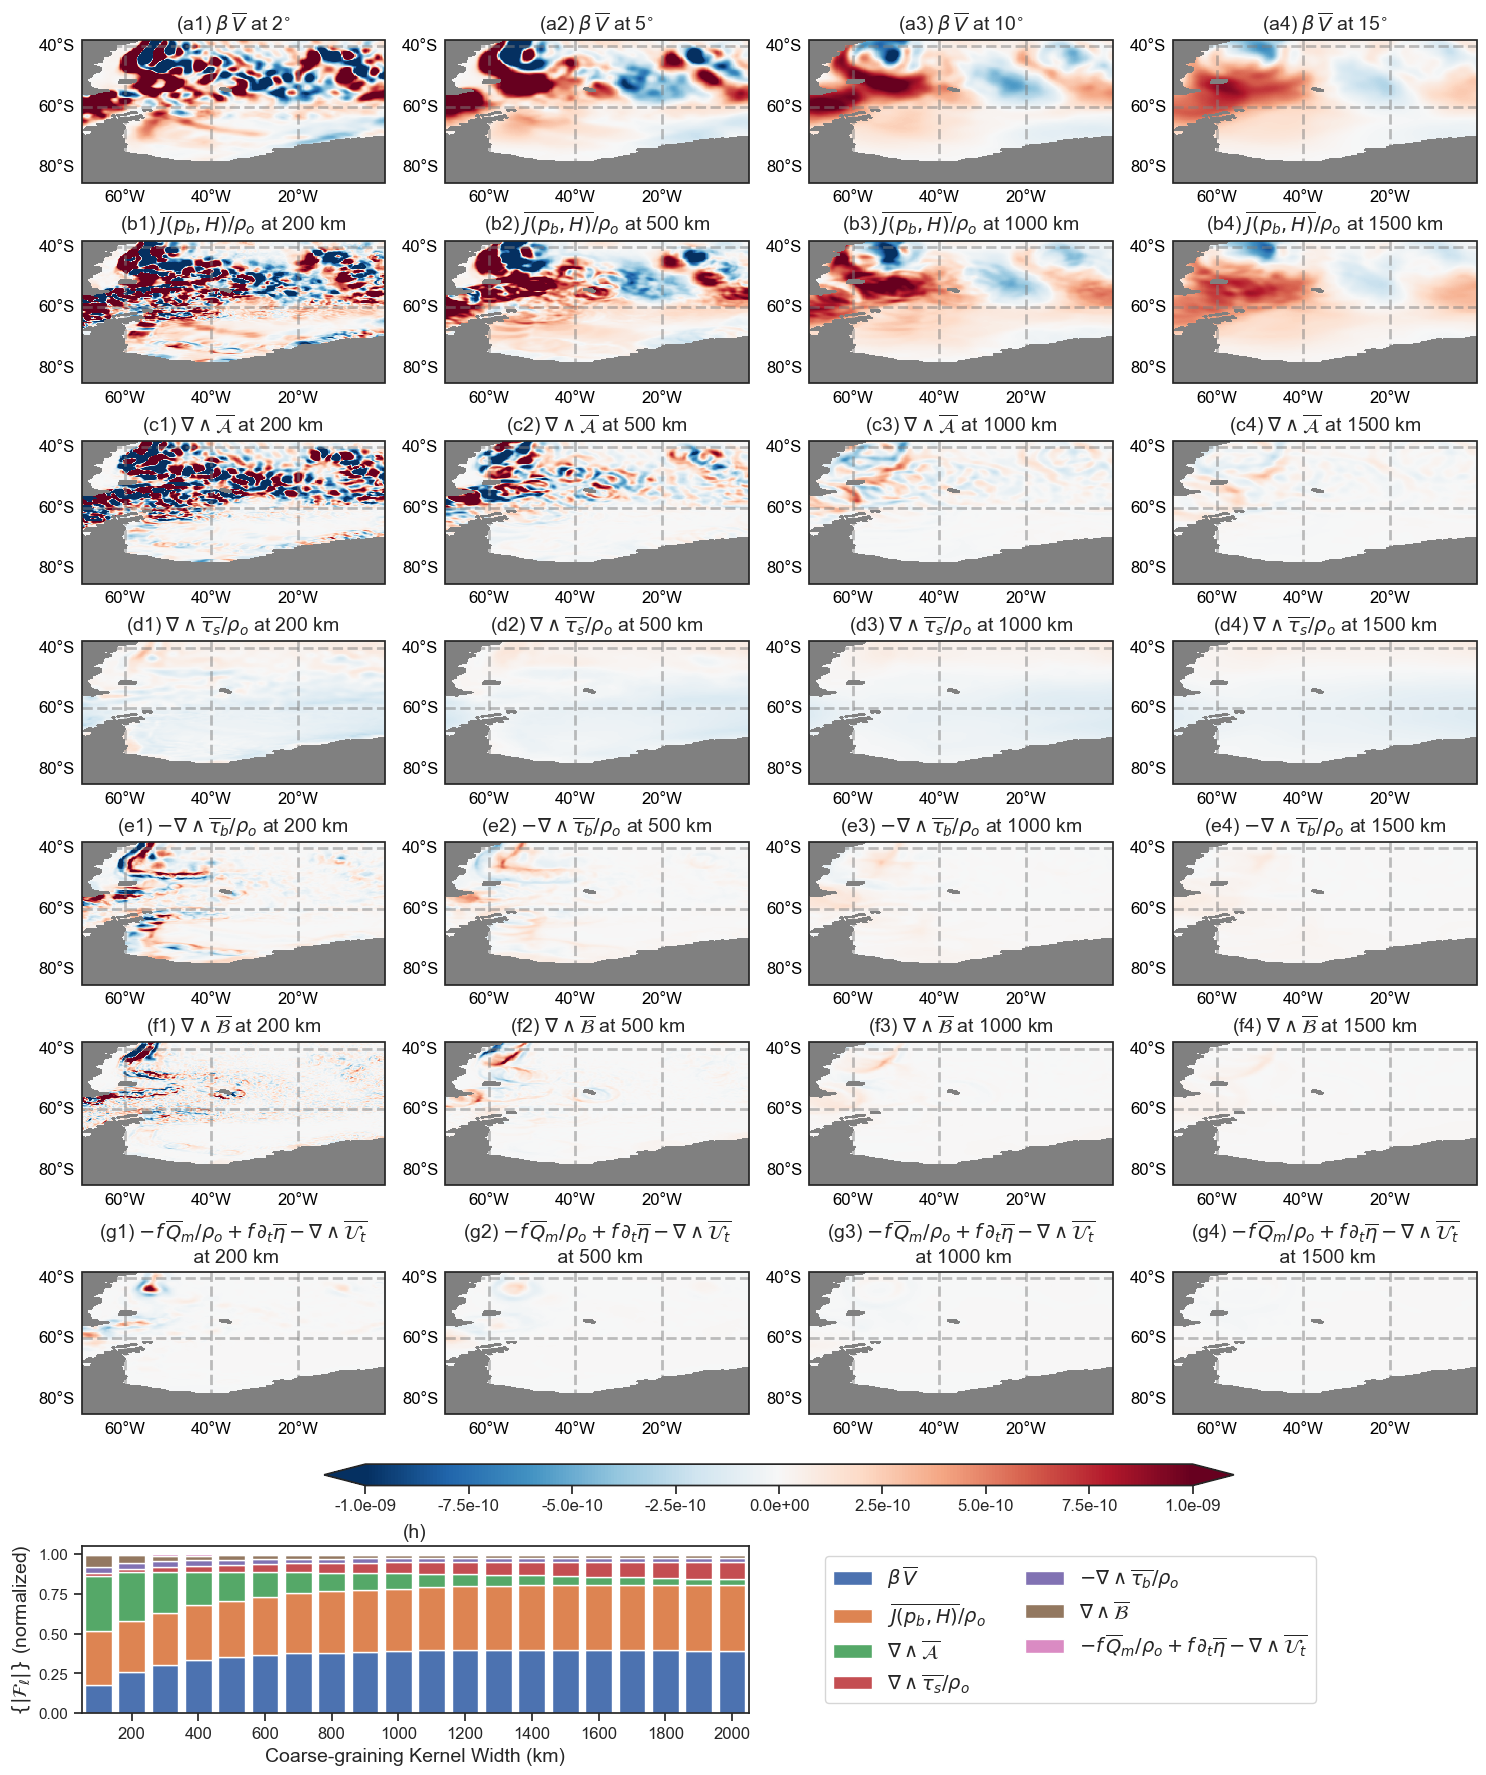

In [14]:
# Plot all coarse-grained terms

ds = (ds_km.sel(latitude = slice(-85., -38.), longitude = slice(-70., 0.))).where(mask_model == 1.)

lat_lon_ext = [-70., 0., -85., -38.]
max_r = 1.0e-9

grid1 = plt.GridSpec(9, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,23])

ind = [1, 4, 9, 14] # 2, 5, 10 and 15 deg
j = 0

rt = 0.7

ax1 = [] 

for i in ind:
    
    ax = fig.add_subplot(grid1[0, j],projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['beta_V'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(97)+str(j+1) + ') ' + r'$\beta \, \overline{V}$ at ' + str(i+1)+'$^{\circ}$',
                aspect_rt = rt)
    if(j==0):
        plt.ylabel(r'$\beta \times V$', fontsize=14)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[1, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['BPT'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(98)+str(j+1) + ') ' + r'$\overline{J(p_b, H)}/\rho_o$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[2, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_Adv'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(99)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{A}}$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[3, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taus'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(100)+str(j+1) + ') ' + r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[4, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taub'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(101)+str(j+1) + ') '  + r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[5, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_diff'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(102)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{B}}$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[6, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, (ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt']).isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(103)+str(j+1) + ') ' +
                 r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$' + '\n at '
                 + str((i+1)*100)+' km', aspect_rt = rt)

    bbox=plt.gca().get_position()
    offset=.005
    plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
    
    ax1.append(ax)
    
    j = j + 1

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(-2.8, -0.5, 3., 3.),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, format='%.1e', extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

# plot rlative magnitudes of domain-mean absolute values
var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Rest']
labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
          r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$', r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$',
          r'$\nabla \wedge \overline{\mathcal{B}}$',
         r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$']

width = 0.8 
d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[7, 0:2])

bbox=plt.gca().get_position()
offset=.02
plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
ax.set_xlim([0.5, 20.5])

bot = 0.  
pos = - 0.0
width = 0.8

norm_fac = d['beta_V'] + d['BPT'] + d['Curl_Adv'] + d['Curl_taus'] + d['Curl_taub'] + d['Curl_diff'] + d['Rest']


for var in var_name:
    
    tmp = d[var] / norm_fac
        
    plt.bar(scale + pos, tmp, width, bottom=bot)
        
    pos = pos + 0.*width
        
    bot = bot + tmp

ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14)   
ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$ (normalized)', fontsize=14)
ax.set_title("(h)", fontsize=14)
plt.xticks(np.arange(2,21,2), np.arange(200, 2100, 200), fontsize=12);

ax.legend(labels, loc='center left', ncol=2,  bbox_to_anchor=(1.1, 0.5), fontsize=14)

fig.savefig('../../Plots/JAMES_Revision/Weddell_Budget.jpg',dpi=300,bbox_inches='tight');
#fig.savefig('../../Plots/JAMES_Revision/Weddell_Budget.png',dpi=300,bbox_inches='tight');

## Central Pacific

$20S - 20N$ and $180W - 100W$

In [15]:
fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']
area = ds_km['cell_areas'].sel(latitude = slice(-20., 20.), longitude = slice(-180., -100.)).isel(filter_scale=0).where(mask1 == 1.)
    
ds = ds_km.sel(latitude = slice(-20., 20.), longitude = slice(-180., -100.)).where(mask1 == 1.)
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

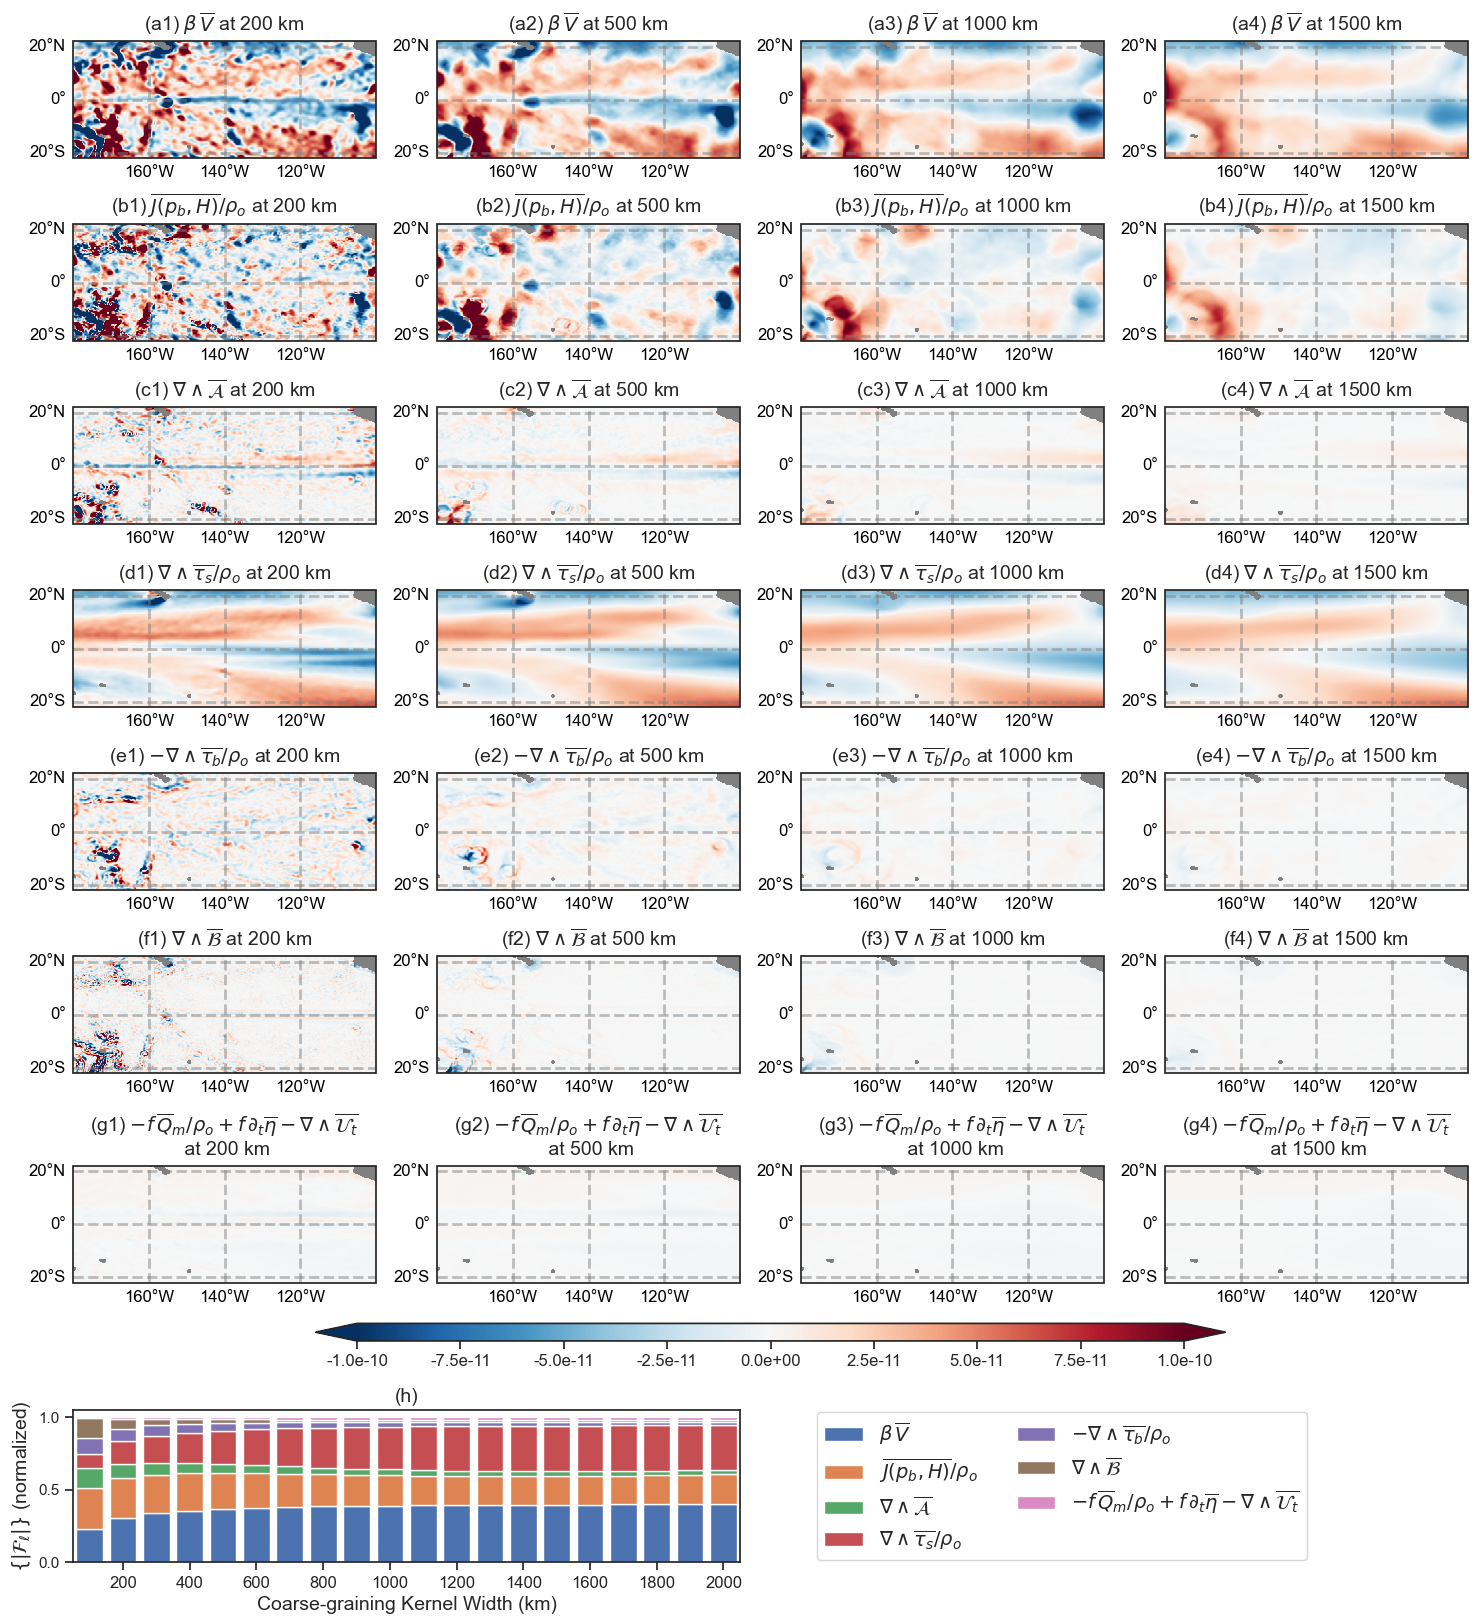

In [16]:
# Plot all terms for filtered in degree

ds = (ds_km.sel(latitude = slice(-22., 22.), longitude = slice(-180., -100.))).where(mask_model == 1.)

lat_lon_ext = [-180., -100., -22., 22.]
max_r = 0.1e-9

grid1 = plt.GridSpec(9, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,21])

ind = [1, 4, 9, 14] # 2, 5, 10 and 15 deg
j = 0

rt = 0.7

ax1 = [] 

for i in ind:
    
    ax = fig.add_subplot(grid1[0, j],projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['beta_V'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(97)+str(j+1) + ') ' + r'$\beta \, \overline{V}$ at '+ str((i+1)*100)+' km',
                aspect_rt = rt)
    if(j==0):
        plt.ylabel(r'$\beta \times V$', fontsize=14)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[1, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['BPT'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(98)+str(j+1) + ') ' + r'$\overline{J(p_b, H)}/\rho_o$ at ' + str((i+1)*100)+' km',
                 aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[2, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_Adv'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(99)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{A}}$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[3, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taus'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(100)+str(j+1) + ') ' + r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$ at '+ str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[4, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taub'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(101)+str(j+1) + ') '  + r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[5, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_diff'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(102)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{B}}$ at ' + str((i+1)*100)+' km',
                aspect_rt = rt)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[6, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, (ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt']).isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(103)+str(j+1) + ') ' +
                 r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$' + '\n at '
                 + str((i+1)*100)+' km',aspect_rt = rt)

    bbox=plt.gca().get_position()
    offset=.005
    plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
    
    ax1.append(ax)
    
    j = j + 1

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(-2.8, -0.5, 3., 3.),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, format='%.1e', extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

# plot rlative magnitudes of domain-mean absolute values
var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Rest']
labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
          r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$', r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$',
          r'$\nabla \wedge \overline{\mathcal{B}}$',
         r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$']

width = 0.8 
d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[7, 0:2])

bbox=plt.gca().get_position()
offset=.02
plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
ax.set_xlim([0.5, 20.5])

bot = 0.  
pos = - 0.0
width = 0.8

norm_fac = d['beta_V'] + d['BPT'] + d['Curl_Adv'] + d['Curl_taus'] + d['Curl_taub'] + d['Curl_diff'] + d['Rest']


for var in var_name:
    
    tmp = d[var] / norm_fac
        
    plt.bar(scale + pos, tmp, width, bottom=bot)
        
    pos = pos + 0.*width
        
    bot = bot + tmp

ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14)   
ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$ (normalized)', fontsize=14)
ax.set_title("(h)", fontsize=14)
plt.xticks(np.arange(2,21,2), np.arange(200, 2100, 200), fontsize=12);

ax.legend(labels, loc='center left', ncol=2,  bbox_to_anchor=(1.1, 0.5), fontsize=14)

fig.savefig('../../Plots/JAMES_Revision/Central_Pacific_Budget.jpg',dpi=300,bbox_inches='tight');
#fig.savefig('../../Plots/JAMES_Revision/Central_Pacific_Budget.png',dpi=300,bbox_inches='tight');

## Global barplot

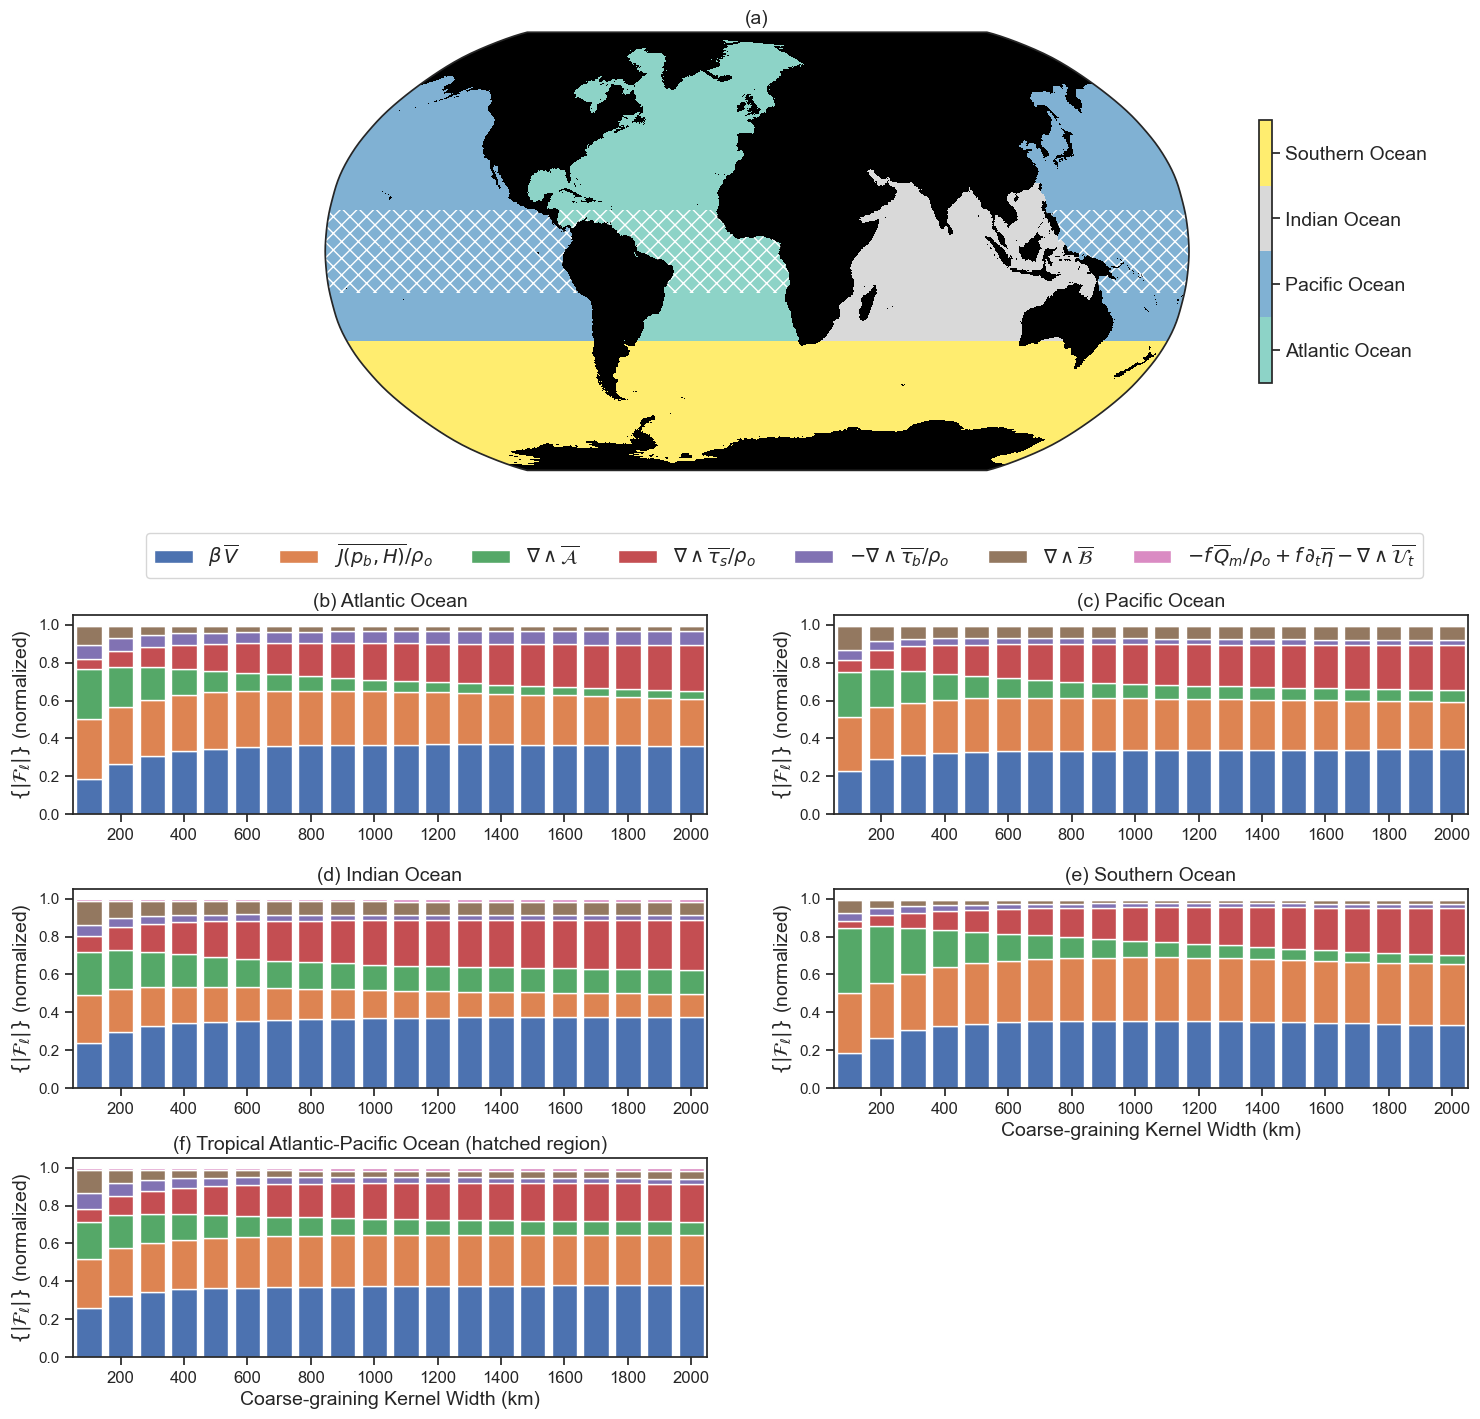

In [17]:
grid1 = plt.GridSpec(5, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,15])

col = plt.cm.get_cmap('Set3', 4)

# mask plot
mask2 = mask1.copy() 
mask2 = xr.where((mask2.latitude > -15.) & (mask2.latitude < 15.) & (mask2 < 2.), 4., mask2) # Tropics in Atlantic and Pacific

ax = fig.add_subplot(grid1[0:2, 0:2], projection=ccrs.Robinson(), facecolor='black')
kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), infer_intervals=False, add_colorbar=False)
p = mask1.plot(cmap=col, vmin=-0.5, vmax = 3.5, **kwargs) #, cbar_kwargs=dict(shrink=0.8, ticks=[0., 1., 2. , 3.]))

#tmp_cfd = da_std['standard_error'] * cfd_per # 95% for outpside 1.96 x sigma
ax.contourf(mask1['longitude'], mask1['latitude'], mask2 > 3.5, transform=ccrs.PlateCarree(), colors='none', 
                    levels=[.5,1.,1.5, 2.], hatches=['xx'])

cb = plt.colorbar(p, ax=ax, shrink=0.6)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticklabels([' ', 'Atlantic Ocean', 'Pacific Ocean', 
                        'Indian Ocean','Southern Ocean'], fontsize=14)
#ax.set_title(f"Full Mask")
#ax.coastlines()
ax.set_title('(a)', fontsize=14)

# loop for computing domain-avg values and barplot

fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']

var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Rest']

label_title = ['(b) Atlantic Ocean', '(c) Pacific Ocean', '(d) Indian Ocean', '(e) Southern Ocean', 
               '(f) Tropical Atlantic-Pacific Ocean (hatched region)']

for i in range(0,5):
    
    if (i > 1):
        j = 1;
    else:
        j = 0;
    
    
    area = ds_km['cell_areas'].isel(filter_scale=0).where(mask2 == i)

    if(i<4):
        ds = ds_km.where(mask1 == i)
    else:
        ds = ds_km.where(mask2 == i)
        
    ds_km_std = xr.Dataset()

    for fld in fldlist:

        if (fld == 'Rest'):
            tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
            tmp = (tmp1 * area).sum(['latitude', 'longitude']) / (area).sum(['latitude', 'longitude'])
        else:
            tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / (area).sum(['latitude', 'longitude'])

        ds_km_std[fld] = tmp
        
    
    # plot
    width = 0.8 
    d = ds_km_std
    scale = np.arange(d.filter_scale.shape[0]) + 1.0

    if(i<4):
        ax = fig.add_subplot(grid1[2 + j, i - 2*j])
        offset=.07
    else:
        ax = fig.add_subplot(grid1[4, 0])
        offset=.085

    bbox=plt.gca().get_position()
    plt.gca().set_position([bbox.x0, bbox.y0 - (j/3. + 1.)*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
    ax.set_xlim([0.5, 20.5])

    bot = 0.

    pos = - 0.0
    width = 0.8

    norm_fac = d['beta_V'] + d['BPT'] + d['Curl_Adv'] + d['Curl_taus'] + d['Curl_taub'] + d['Curl_diff'] + d['Rest']

    labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
              r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$', r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$',
              r'$\nabla \wedge \overline{\mathcal{B}}$',
             r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$']

    for var in var_name:

        tmp = d[var] / norm_fac

        plt.bar(scale + pos, tmp, width, bottom=bot)

        pos = pos + 0.*width

        bot = bot + tmp

    if(i>2):
        ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14)   
    ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$ (normalized)', fontsize=14)
    plt.xticks(np.arange(2,21,2), np.arange(200, 2100, 200), fontsize=12);
    ax.set_title(label_title[i], fontsize=14)
    if (i==0):
        ax.legend(labels, loc='center left', ncol=7,  bbox_to_anchor=(0.1, 1.3), fontsize=14)

        
fig.savefig('../../Plots/JAMES_Revision/Global_Budget.jpg',dpi=300,bbox_inches='tight');
#fig.savefig('../../Plots/JAMES_Revision/Global_Budget.png',dpi=300,bbox_inches='tight');

## Spatial map for grid-wise vorticity balances

Here, we plot the spatial maps for main voritciy balanaces (color-coded) at 2, 5, 10 and 20 degree resolutions.

Kernel Grid size in km =  200
Total grid points =  591663.0 , Total surface area =  346071630952780.4
V_BPT_A surface area % =  0.16139229146488251
V_taus_BPT surface area % =  0.22038007425232012
V_taus surface area % =  0.053142207415906896
V_taub_B surface area % =  0.0014602244611373273
Other surface area % =  0.5636252024057535
 
Kernel Grid size in km =  500
Total grid points =  591663.0 , Total surface area =  346071630952780.4
V_BPT_A surface area % =  0.12822821323942324
V_taus_BPT surface area % =  0.34727281642540186
V_taus surface area % =  0.16216593692623776
V_taub_B surface area % =  0.0006237530475928974
Other surface area % =  0.3617092803613445
 
Kernel Grid size in km =  1000
Total grid points =  591663.0 , Total surface area =  346071630952780.4
V_BPT_A surface area % =  0.09157875074934967
V_taus_BPT surface area % =  0.3846981483640725
V_taus surface area % =  0.22835681125475898
V_taub_B surface area % =  0.0005663845669566631
Other surface area % =  0.2947999050

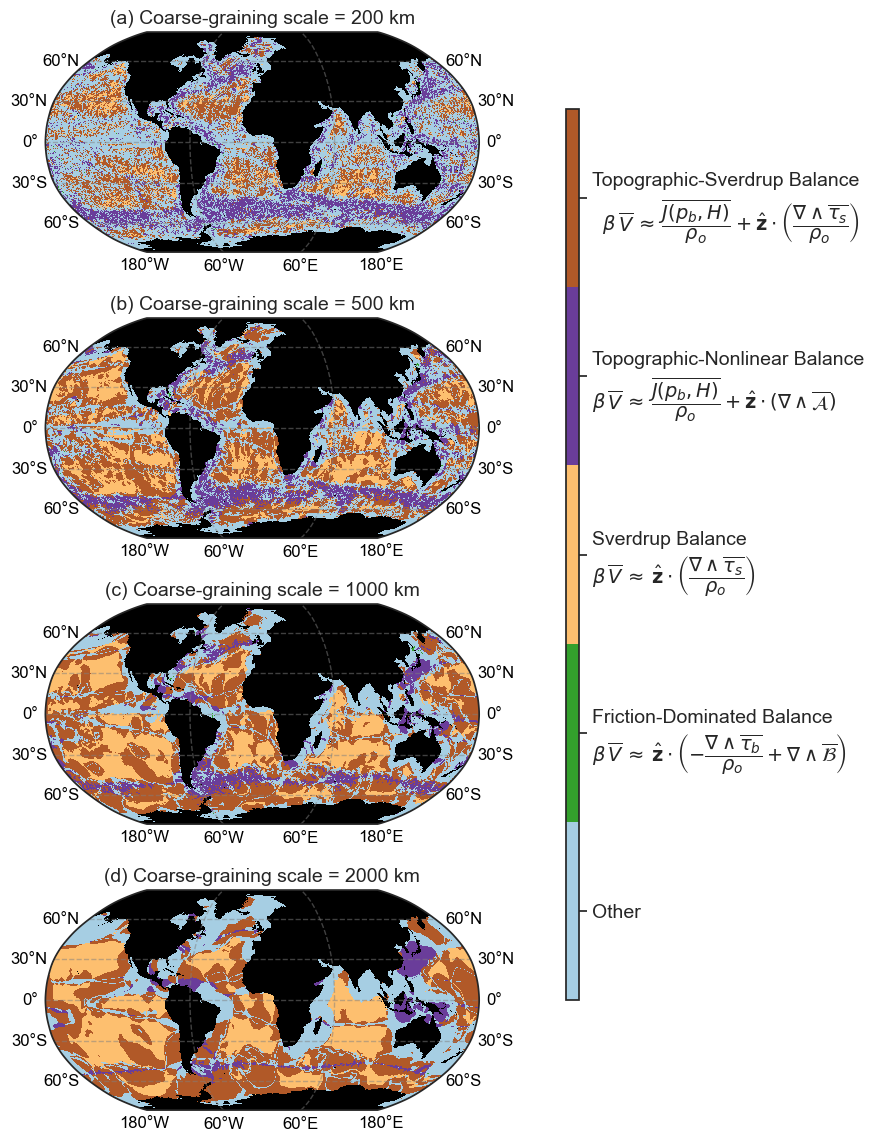

In [18]:
i_ind = [1, 4, 9, 19]

fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']

cut_off = 0.8

col = plt.cm.get_cmap('Paired', 5)

#palette = sns.color_palette("tab10", 10)
#palette = sns.color_palette([palette[0], palette[1], palette[3], palette[4], palette[5]], as_cmap=True)
#col = palette

grid1 = plt.GridSpec(4, 1, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[14,14])

for i in range(0, len(i_ind)):
    
    print("Kernel Grid size in km = ", (i_ind[i] +1)*100)

    ds = np.abs(ds_km.isel(filter_scale = i_ind[i])).where(mask1 < 10.)

    area = ds_km['cell_areas'].isel(filter_scale=0).where(mask1 < 10.)
    
    total_grid = ((mask1+0.1)/(mask1+0.1)).sum().values
    total_area = area.sum().values
    
    print("Total grid points = ", ((mask1+0.1)/(mask1+0.1)).sum().values, ", Total surface area = ", total_area)

    # ---- Compute normalizing factor ----------
    norm_fac = ds['beta_V'] * 0.

    for fld in fldlist:

        if (fld == 'Rest'):
            norm_fac = norm_fac + np.abs(ds['Mass_flux']) + np.abs(ds['eta_dt']) + np.abs(ds['Curl_dudt'])
        else:
            norm_fac = norm_fac + np.abs(ds[fld])

    #norm_fac = np.sqrt(norm_fac)
    norm_fac = norm_fac.where(mask1 < 10.)
    
    # ------- Compute leading vorticity balances ---------
    ds_map = xr.Dataset()

    Rest_tmp = np.maximum(np.abs(ds['Mass_flux']), np.maximum(np.abs(ds['eta_dt']), np.abs(ds['Curl_dudt'])))
    
    # Check Topographic-nonlinear balance
    tmp = ((np.abs(ds['beta_V']) + np.abs(ds['BPT']) + np.abs(ds['Curl_Adv']))/norm_fac)
    tmp1 = tmp.where(tmp >= cut_off)

    a = np.minimum(np.abs(ds['beta_V']), np.minimum(np.abs(ds['BPT']), np.abs(ds['Curl_Adv'])))
    b = np.maximum(np.abs(ds['Curl_taub']), 
                   np.maximum(np.abs(ds['Curl_taus']), np.maximum(np.abs(ds['Curl_diff']), Rest_tmp)))

    ds_map['V_BPT_A'] = tmp1.where(a > b)
    
    #print("V_BPT_A grid points % = ", ((tmp1+0.1)/(tmp1+0.1)/total_grid).sum().values)
    
    # Check Topographic-Sverdrup balance
    tmp = ((np.abs(ds['beta_V']) + np.abs(ds['BPT']) + np.abs(ds['Curl_taus']))/norm_fac)
    tmp1 = tmp.where(tmp >= cut_off)

    a = np.minimum(np.abs(ds['beta_V']), np.minimum(np.abs(ds['BPT']), np.abs(ds['Curl_taus'])))
    b = np.maximum(np.abs(ds['Curl_taub']), 
                   np.maximum(np.abs(ds['Curl_Adv']), np.maximum(np.abs(ds['Curl_diff']), Rest_tmp)))

    ds_map['V_taus_BPT'] = tmp1.where(a > b)
    
    #print("V_taus_BPT grid points % = ", ((tmp1+0.1)/(tmp1+0.1)/total_grid).sum().values)
    
    # Check Sverdrup balance
    tmp = ((np.abs(ds['beta_V']) + np.abs(ds['Curl_taus']))/norm_fac)
    tmp1 = tmp.where(tmp >= cut_off)

    a = np.minimum(np.abs(ds['beta_V']), np.abs(ds['Curl_taus']))
    b = np.maximum(np.abs(ds['Curl_taub']), 
                   np.maximum(np.abs(ds['Curl_Adv']), 
                              np.maximum(np.abs(ds['Curl_diff']), 
                                         np.maximum(np.abs(ds['BPT']), Rest_tmp))))

    ds_map['V_taus'] = tmp1.where(a > b)
    
    #print("V_taus grid points % = ", ((tmp1+0.1)/(tmp1+0.1)/total_grid).sum().values)

    # Check Friction-dominated balance
    tmp = ((np.abs(ds['beta_V']) + np.abs(ds['Curl_taub']) + np.abs(ds['Curl_diff']))/norm_fac)
    tmp1 = tmp.where(tmp >= cut_off)

    a = np.minimum(np.abs(ds['beta_V']), np.minimum(np.abs(ds['Curl_taub']), np.abs(ds['Curl_diff'])))
    b = np.maximum(np.abs(ds['BPT']), 
                   np.maximum(np.abs(ds['Curl_Adv']), np.maximum(np.abs(ds['Curl_taus']), Rest_tmp)))

    ds_map['V_taub_B'] = tmp1.where(a > b)
    
    #print("V_taub_B grid points % = ", ((tmp1+0.1)/(tmp1+0.1)/total_grid).sum().values)
    
    #print (" ")
    
    # -------- assign numbers for plotting ----------
    tmp_map = (mask.copy()*0.).where(mask1 < 10.)

    tmp_map = xr.where(ds_map['V_taus_BPT']>0., 4., tmp_map)
    tmp_map = xr.where(ds_map['V_taus']>0., 2., tmp_map) # should be after V_taus_BPT
                                                        # because V_taus and V_taus_BPT will have common grid points
    tmp_map = xr.where(ds_map['V_BPT_A']> 0., 3., tmp_map)
    tmp_map = xr.where(ds_map['V_taub_B']> 0., 1., tmp_map)
    
    print("V_BPT_A surface area % = ", #(tmp_map.where(tmp_map==3.)/3./total_grid).sum().values)
          area.where(tmp_map==3.).sum().values / total_area)
    print("V_taus_BPT surface area % = ", #(tmp_map.where(tmp_map==4.)/4./total_grid).sum().values)
          area.where(tmp_map==4.).sum().values / total_area)
    print("V_taus surface area % = ", #(tmp_map.where(tmp_map==2.)/2./total_grid).sum().values)
          area.where(tmp_map==2.).sum().values / total_area)
    print("V_taub_B surface area % = ", #(tmp_map.where(tmp_map==1.)/total_grid).sum().values)
          area.where(tmp_map==1.).sum().values / total_area)
    print("Other surface area % = ", #((tmp_map.where(tmp_map==0.)+1.)/total_grid).sum().values)
          area.where(tmp_map==0.).sum().values / total_area)
    
    
    print (" ")
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.Robinson(), facecolor='black')
    kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), 
                  infer_intervals=False, add_colorbar=False)
    p = tmp_map.where(mask1 < 10.).plot(cmap=col, vmin=-0.5, vmax = 4.5, **kwargs) #, cbar_kwargs=dict(shrink=0.8, ticks=[0., 1., 2. , 3.]))

    #ax.coastlines()
    ax.set_title('('+chr(97+i)+') ' + 'Coarse-graining scale = ' + 
                 str((i_ind[i]+1)*100)+r' km', fontsize=14)
    #lat-lon labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylocator = mticker.FixedLocator(np.arange(-60,81,30))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,120))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    #gl.xlabels_top = False
    #gl.ylabels_right = False
    gl.top_labels = False
    #gl.right_labels = False
    #gl.ylines = False
    #gl.xlines = False
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.2, 0.5, 3., 4.5),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, format='%.1e') #, orientation="horizontal")
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticks((0, 1, 2, 3, 4));
cb.ax.set_yticklabels(['Other', #'V_tau_B', #'V_tau_tau', # 'V_BPT_A',#'V_tau_BPT',
                       'Friction-Dominated Balance \n' + r'$\beta \, \overline{V} \, \approx \, \hat{\mathbf{z}} \cdot \left(- \dfrac{\nabla \wedge\overline{{\tau_b}}}{\rho_o} + \nabla \wedge \overline{\mathcal{B}} \right)$',
                       'Sverdrup Balance \n' + r'$\beta \, \overline{V} \, \approx \, \hat{\mathbf{z}} \cdot \left(\dfrac{\nabla \wedge\overline{{\tau_s}}}{\rho_o} \right)$',
                       'Topographic-Nonlinear Balance \n' + r'$\beta \, \overline{V} \, \approx \, \dfrac{\overline{J(p_b, H)}}{\rho_o} + \hat{\mathbf{z}} \cdot \left(\nabla \wedge \overline{\mathcal{A}} \right)$',
                       'Topographic-Sverdrup Balance \n' + r'  $\beta \, \overline{V} \, \approx \, \dfrac{\overline{J(p_b, H)}}{\rho_o} + \hat{\mathbf{z}} \cdot \left(\dfrac{\nabla \wedge\overline{{\tau_s}}}{\rho_o} \right)$'
                      ], fontsize=14);

#fig.savefig('../../Plots/JAMES_Revision/Global_budget_map.png',dpi=300,bbox_inches='tight');
fig.savefig('../../Plots/JAMES_Revision/Global_budget_map.jpg',dpi=300,bbox_inches='tight');


## Vorticity balance within North Atlantic Gyres

We examine scale-depedence of vorticity balances with in gyres. For this purpose, we first need to compute streamfunction to determine the gyre boundary. We integrate depth-integrated velocity $V(x,y)$ in the zonal direction.

$$\psi(x,y) = \int_{x_w}^{x} V(x,y)dx$$

Text(0, 0.5, 'dx')

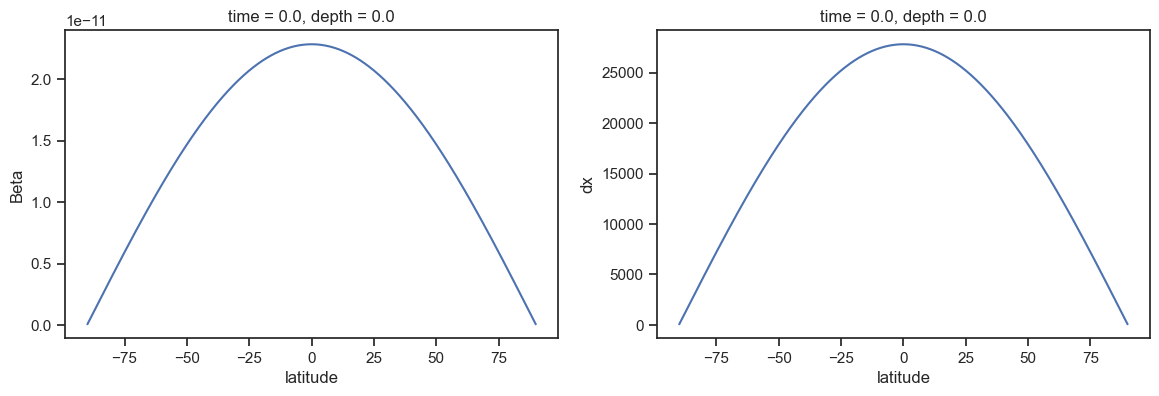

In [19]:
#ds_deg['beta_V']

# Compute beta and dx

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

beta = 2*OMEGA*np.cos(ds_km['latitude'] * np.pi /180.)/RAD_EARTH

d_lon = 0.25

dx = d_lon * np.cos(ds_km['latitude'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.)

fig = plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
beta.plot()
plt.ylabel('Beta')

plt.subplot(1,2,2)
dx.plot()
plt.ylabel('dx')

In [20]:
# Comupte psi

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

beta = 2*OMEGA*np.cos(ds_km['latitude'] * np.pi /180.)/RAD_EARTH

d_lon = 0.25
dx = d_lon * np.cos(ds_km['latitude'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.)

V = (ds_km['beta_V'].isel(filter_scale = 4) /beta).where((mask1 == 0.) | (mask1 == 3.)) # let's choose field filtered to 500 km in the North Atlantic

psi = (V * dx).cumsum('longitude') 

psi = (psi - psi.isel(longitude=0)) / 1.e6

#psi

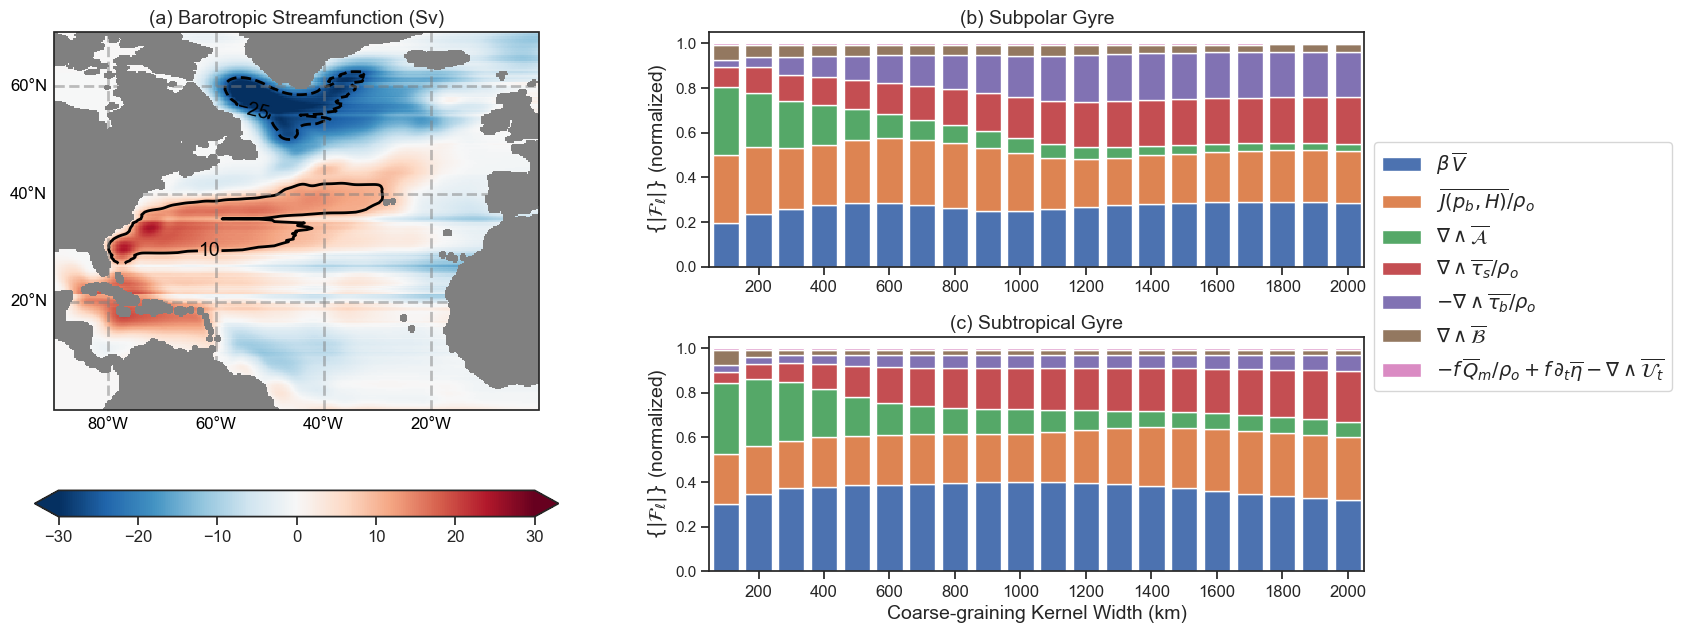

In [21]:
lat_lon_ext = [-90., 0., 0., 70.]

max_r = 30.
psi_lev = [-25., 10.]

grid1 = plt.GridSpec(2, 4, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,7])

ax = fig.add_subplot(grid1[0:2, 0:2],projection=ccrs.PlateCarree(),facecolor='grey')
p = plot_sec(ax, psi.where(mask_model == 1.), vmin=-max_r, vmax=max_r, vstep=2.e-3, 
             lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
             title=r'(a) Barotropic Streamfunction (Sv)')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8, orientation="horizontal")
cb.ax.tick_params(labelsize=12)
contours = ax.contour(psi.longitude, psi.latitude, 
                      psi.where((mask1 == 0) & (psi.latitude > 27.)), levels = [-25., 10.], 
                      colors='black',linewidths=2)
plt.clabel(contours, inline=True, fontsize=14)

# loop for computing domain-avg values and barplot

fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']
var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Rest']

label_title = ['(b) Subpolar Gyre', '(c) Subtropical Gyre']

for i in range(0,len(psi_lev)):

    if(i==1):
        ds = ds_km.where((mask1 == 0.) & (psi >= psi_lev[i]) & (psi.latitude > 27.))
        area = ds_km['cell_areas'].isel(filter_scale=0).where((mask1 == 0.) & (psi >= psi_lev[i]) & (psi.latitude > 27.))
    else:
        ds = ds_km.where((mask1 == 0.) & (psi <= psi_lev[i]) & (psi.latitude > 27.))
        area = ds_km['cell_areas'].isel(filter_scale=0).where((mask1 == 0.) & (psi <= psi_lev[i]) & (psi.latitude > 27.))
        
    ds_km_std = xr.Dataset()

    for fld in fldlist:

        if (fld == 'Rest'):
            tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
            tmp = (tmp1 * area).sum(['latitude', 'longitude']) / (area).sum(['latitude', 'longitude'])
        else:
            tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / (area).sum(['latitude', 'longitude'])

        ds_km_std[fld] = tmp
        
    
    # plot
    width = 0.8 
    d = ds_km_std
    scale = np.arange(d.filter_scale.shape[0]) + 1.0
    
    ax = fig.add_subplot(grid1[i, 2:4])
    
    bot = 0.
    pos = - 0.0
    width = 0.8

    norm_fac = d['beta_V'] + d['BPT'] + d['Curl_Adv'] + d['Curl_taus'] + d['Curl_taub'] + d['Curl_diff'] + d['Rest']

    labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
              r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$', r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$',
              r'$\nabla \wedge \overline{\mathcal{B}}$', #'Rest']
              r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$']

    for var in var_name:

        tmp = d[var] / norm_fac

        plt.bar(scale + pos, tmp, width, bottom=bot)

        pos = pos + 0.*width

        bot = bot + tmp

    if(i>0):
        ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14)   
    ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$ (normalized)', fontsize=14)
    plt.xticks(np.arange(2,21,2), np.arange(200, 2100, 200), fontsize=12);
    ax.set_xlim([0.5, 20.5])
    ax.set_title(label_title[i], fontsize=14)
    if (i==0):
        ax.legend(labels, loc='center left', bbox_to_anchor=(1.0, 0.0), fontsize=14)
        
fig.savefig('../../Plots/JAMES_Revision/Gyre_Budget.jpg',dpi=300,bbox_inches='tight');
#fig.savefig('../../Plots/JAMES_Revision/Gyre_Budget.png',dpi=300,bbox_inches='tight');

(5e-12, 5e-10)

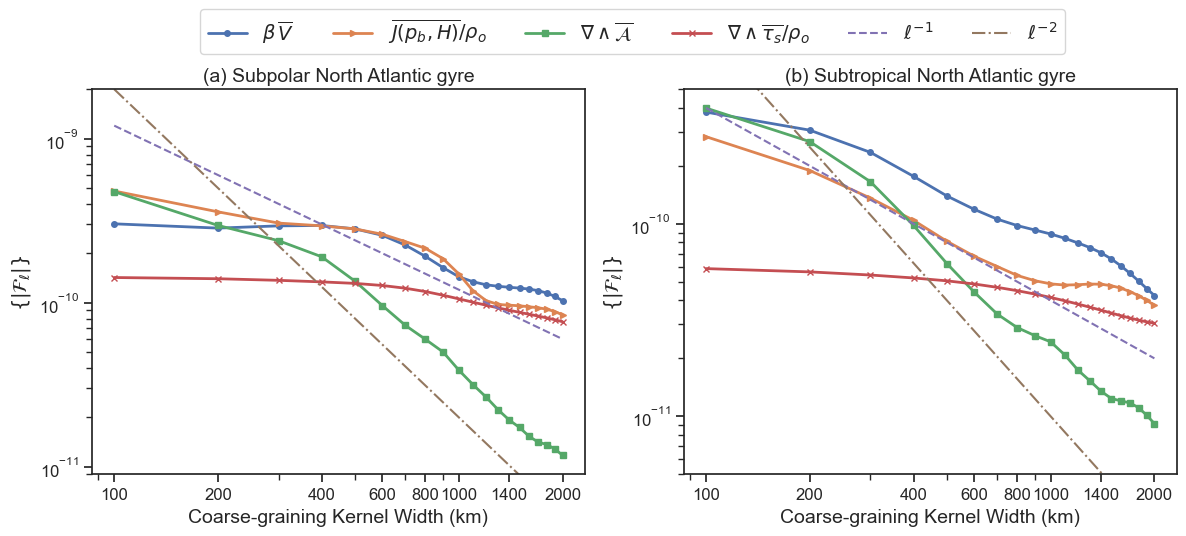

In [14]:
# scaling laws for vorticity budget terms
# use two regions (subpolar North Atlantic and subtropical North Atlantic gyres)


grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[14,5])

psi_lev = [-25., 10.]
fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']

var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus'] #, 'Curl_taub', 'Curl_diff', 'Rest']
labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
          r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$']

# Subpolar gyre 
area = ds_km['cell_areas'].isel(filter_scale=0).where((mask1 == 0.) & (psi <= psi_lev[0]) & (psi.latitude > 27.))
    
ds = ds_km.where((mask1 == 0.) & (psi <= psi_lev[0]) & (psi.latitude > 27.))
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[0, 0])
i=0
marke = ['o', '>', 's', 'x']
for var in var_name:
    plt.loglog(scale, d[var], ls ='-', lw=2, marker= marke[i], ms=4, label=labels[i])
    i=i+1

ax.loglog(scale, 1.2e-9/scale, '--', label=r'$\ell^{-1}$')
ax.loglog(scale, 2e-9/scale**2, '-.', label=r'$\ell^{-2}$')
ax.legend(loc='center left', ncol=6,  bbox_to_anchor=(0.2, 1.15), fontsize=14)
#ax.grid('on', ls='--')
tick_Labels = [r'100', r'2$^{\circ}$', r'4$^{\circ}$', r'6$^{\circ}$', r'8$^{\circ}$', r'10$^{\circ}$',
               r'14$^{\circ}$', r'20$^{\circ}$']
plt.xticks([1,2,4,6,8,10,14,20], [100,200,400,600,800,1000,1400,2000], fontsize=12);
plt.yticks(fontsize=12)
ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14);  
ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$', fontsize=14);
ax.set_title(r'(a) Subpolar North Atlantic gyre', fontsize=14)
ax.set_ylim([0.9e-11, 2.e-9])


# Subtropical gyre
area = ds_km['cell_areas'].isel(filter_scale=0).where((mask1 == 0.) & (psi >= psi_lev[1]) & (psi.latitude > 27.))
    
ds = ds_km.where((mask1 == 0.) & (psi >= psi_lev[1]) & (psi.latitude > 27.))
ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['latitude', 'longitude']) / area.sum(['latitude', 'longitude'])
        
    ds_km_std[fld] = tmp

d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[0, 1])
i=0
marke = ['o', '>', 's', 'x']
for var in var_name:
    plt.loglog(scale, d[var], ls ='-', lw=2, marker= marke[i], ms=4, label=labels[i])
    i=i+1

ax.loglog(scale, 0.4e-9/scale, '--', label=r'$\ell^{-1}$')
ax.loglog(scale, 1e-9/scale**2, '-.', label=r'$\ell^{-2}$')
#ax.legend(loc='center left',  bbox_to_anchor=(1., 0.5), fontsize=14)
#ax.grid('on', ls='--')
tick_Labels = [r'100', r'2$^{\circ}$', r'4$^{\circ}$', r'6$^{\circ}$', r'8$^{\circ}$', r'10$^{\circ}$',
               r'14$^{\circ}$', r'20$^{\circ}$']
plt.xticks([1,2,4,6,8,10,14,20], [100,200,400,600,800,1000,1400,2000], fontsize=12);
plt.yticks(fontsize=12)
ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14);  
ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$', fontsize=14);
ax.set_title(r'(b) Subtropical North Atlantic gyre', fontsize=14)
ax.set_ylim([0.5e-11, 0.5e-9])

#### Latitudinal dependence

We plot the zonal-mean absolute magnitudes, $\{|\mathcal{F}_\ell|\}$, of vorticity budget terms.


In [29]:
fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']

ds = ds_km.where(mask_model > 0.)
ds_km_std = xr.Dataset()

area = ds_km['cell_areas'].isel(filter_scale=0).where(mask_model > 0.)

for fld in fldlist:
    if (fld == 'Rest'):
        tmp1 = np.abs(ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt'])
        tmp = (tmp1 * area).sum(['longitude']) / (area).sum(['longitude'])
    else:
        tmp = (np.abs(ds[fld]) * area).sum(['longitude']) / (area).sum(['longitude'])

    ds_km_std[fld] = tmp


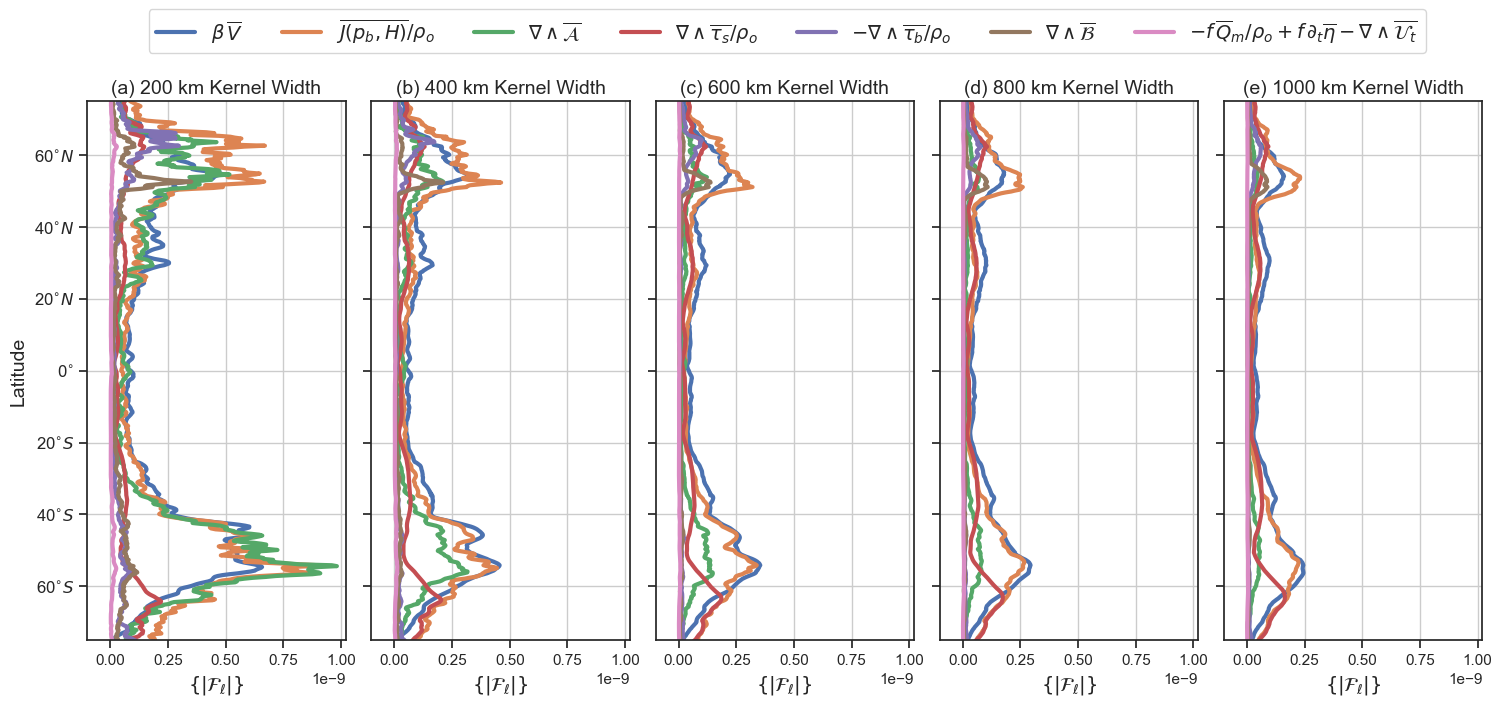

In [34]:
var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff' , 'Rest']

labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
          r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$', r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$',
          r'$\nabla \wedge \overline{\mathcal{B}}$' ,
         r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$']

tick_Labels = [r'60$^{\circ}S$', r'40$^{\circ}S$', r'20$^{\circ}S$', r'0$^{\circ}$', r'20$^{\circ}N$', 
               r'40$^{\circ}N$', r'60$^{\circ}N$']

label_title = [r'(a) 200 km Kernel Width', r'(b) 400 km Kernel Width', r'(c) 600 km Kernel Width',
              r'(d) 800 km Kernel Width', r'(e) 1000 km Kernel Width']

grid1 = plt.GridSpec(1, 5, wspace=0.1, hspace=0.2)
fig = plt.figure(figsize=[18,7])

k = 0
for i in range(2,11,2):
    
    ax = fig.add_subplot(grid1[0,k])
    k= k + 1
    
    for var in var_name:
    
        ax.plot(ds_km_std[var].isel(filter_scale=i-1), ds_km_std.latitude, lw=3.)
        ax.grid('on')
        
        if(k==1):
            ax.set_ylabel("Latitude", fontsize=14)   
        ax.set_xlabel(r'$\{|\mathcal{F}_\ell|\}$', fontsize=14)
        
        if (k==1):
            ax.legend(labels, loc='center left', ncol=7,  bbox_to_anchor=(0.2, 1.13), fontsize=14)
            
    ax.set_ylim(-75, 75)
    ax.set_xlim(-1.e-10, 1.02e-9)
    if (k==1):
        plt.yticks(np.arange(-60,61,20), tick_Labels, fontsize=12);
    else:
        plt.yticks(np.arange(-60,61,20), [], fontsize=12);
        
    ax.set_title(label_title[k-1], fontsize=14)
    
fig.savefig('../../Plots/JAMES_Revision/Lat_Kernel.pdf',dpi=300,bbox_inches='tight');